#### 这个文档是训练模型专用

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

#加载数据的方法
def load_dataset(path):
    data = load_files(path)
    print(type(data))
    data_files = np.array(data['filenames'])
    print(data_files[0])
#     data_targets = np_utils.to_categorical(np.array(data['target']), 2)
    data_targets = np.array(data['target'])
    return data_files,data_targets

Using TensorFlow backend.


In [5]:
#加载所有的处理过的猫狗数据
train_files,train_targets=load_dataset('train_set')

<class 'sklearn.utils.Bunch'>
train_set/cat/cat.3557.jpg


In [6]:
#打印下看看有没有问题
print(train_files[0],train_targets[0])

train_set/cat/cat.3557.jpg 0


In [4]:
#注意,不能直接加载数据集然后再分割,因为这样很占用内存
from sklearn.model_selection import train_test_split

X=train_files
Y=train_targets
x_train,x_valid,y_train,y_valid=train_test_split(X,Y,test_size=0.2,random_state=8888)

In [5]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras import Model


base_model=InceptionResNetV2(weights='imagenet',include_top=False)
for layer in base_model.layers:
    layer.trainable=False
    
x=GlobalAveragePooling2D()(base_model.output)
x=Dense(512)(x)
x=Dropout(0.2)(x)
# 添加一个分类器，我们有2个类
predictions=Dense(1,activation='sigmoid')(x)

# 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
for i, layer in enumerate(model.layers):
    print(i, layer.name)
    
#输出模型的样式
model.summary()

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed_5b
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 conv2d_13
51 conv2d_15
52 conv2d_18
53 batch_normalization_13
54 batch_normalization_15
55 batch_normalization

block17_5_conv (Conv2D)         (None, None, None, 1 418880      block17_5_mixed[0][0]            
__________________________________________________________________________________________________
block17_5 (Lambda)              (None, None, None, 1 0           block17_4_ac[0][0]               
                                                                 block17_5_conv[0][0]             
__________________________________________________________________________________________________
block17_5_ac (Activation)       (None, None, None, 1 0           block17_5[0][0]                  
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, None, None, 1 139264      block17_5_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, None, None, 1 384         conv2d_98[0][0]                  
__________

In [ ]:
#展示模型,因为要安装额外软件,所以linux就注释掉了
#from keras.utils import plot_model
#pip install pydot
#pip install pydot-ng
#pip install graphviz 
#参考https://blog.csdn.net/u011311291/article/details/80298563
#https://packages.ubuntu.com/search?keywords=graphviz&searchon=names
#plot_model(model, to_file='model.png',show_shapes=True)

In [12]:
#另一种可视化模型的方法
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [11]:
#接下来的处理方式是将所有的图片都处理成向量
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input as ir_preprocess_input
from tqdm import tqdm

##pip install  tqdm
#注意要安装tqdm
def path_to_tensor(image_path,target_size=(299,299)):
    '''将图片转换为tensor向量'''
    img=image.load_img(image_path,target_size=target_size)
    x=image.img_to_array(img)
    x=ir_preprocess_input(x)
    return np.expand_dims(x,axis=0)

def paths_to_tensor(image_paths):
    '''批量将图片转换为tensor'''
    list_of_tensor=[path_to_tensor(image_path) for image_path in tqdm(image_paths)]
    return np.vstack(list_of_tensor)
    

In [9]:
#训练模型看看
from keras.callbacks import ModelCheckpoint
import os
###设置训练模型的epochs的数量
epochs = 15
batch_size=50
check_point_filepath='./saved_models/weights.best-{epoch:02d}-{val_acc:.2f}.hdf5'
saved_model_path='./saved_models'

#文件夹不存在,就创建文件夹
if not os.path.exists(saved_model_path):
    os.mkdir()
    
####设置检查点
checkpointer = ModelCheckpoint(filepath=check_point_filepath, monitor='val_acc',verbose=1, save_best_only=True)

#设置回调
call_back=[checkpointer]

#加载数据
x_train_data=paths_to_tensor(x_train)
x_valid_data=paths_to_tensor(x_valid)

100%|██████████| 4967/4967 [00:27<00:00, 183.64it/s]


In [17]:
#开始训练
epochs=15
history= model.fit(x_train_data,y_train,validation_data=(x_valid_data,y_valid),epochs=epochs,batch_size=50,callbacks=call_back)

Train on 19868 samples, validate on 4967 samples
Epoch 1/15
19868/19868 [==============================] - 165s 8ms/step - loss: 0.0349 - acc: 0.9883 - val_loss: 0.1207 - val_acc: 0.9644

Epoch 00001: val_acc did not improve from 0.98752
Epoch 2/15
19868/19868 [==============================] - 164s 8ms/step - loss: 0.0391 - acc: 0.9863 - val_loss: 0.0978 - val_acc: 0.9748

Epoch 00002: val_acc did not improve from 0.98752
Epoch 3/15
19868/19868 [==============================] - 164s 8ms/step - loss: 0.0357 - acc: 0.9868 - val_loss: 0.0585 - val_acc: 0.9841

Epoch 00003: val_acc did not improve from 0.98752
Epoch 4/15
19868/19868 [==============================] - 164s 8ms/step - loss: 0.0348 - acc: 0.9882 - val_loss: 0.0420 - val_acc: 0.9881

Epoch 00004: val_acc improved from 0.98752 to 0.98812, saving model to ./saved_models/weights.best-04-0.99.hdf5
Epoch 5/15
19868/19868 [==============================] - 164s 8ms/step - loss: 0.0345 - acc: 0.9878 - val_loss: 0.0423 - val_acc: 0.

In [10]:
#展示Accuracy数据
import matplotlib.pyplot as plt

def show_acc(history):
    print(history.history.keys())
    figure=plt.figure()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accucary')
    plt.xlabel('accuracy')
    plt.ylabel('epoch')
    #注意!
    plt.legend(['train','valid'],loc='upper left')
    figure.savefig('performance_acc.png')
    

#展示Loss数据  
def show_loss(history):
    print(history.history.keys())
    figure=plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Loss')
    plt.ylabel('epoch')
    #注意!
    plt.legend(['train','valid'],loc='upper left')
    figure.savefig('performance_loss.png')

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


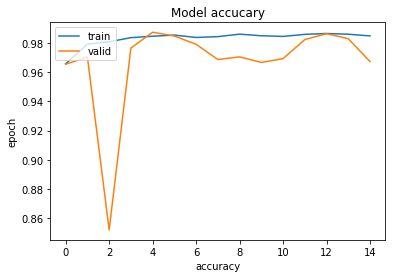

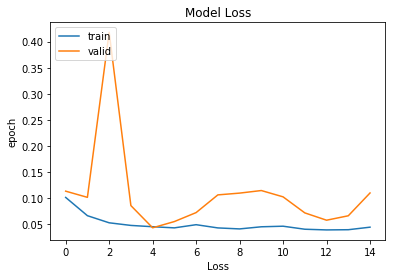

In [16]:
# # show_history(history)

# fig = plt.figure()
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='lower left')

# fig.savefig('performance.png')
#展示训练后的数据
#batch=40的时候
show_acc(history)
show_loss(history)

#### 目前遭遇了一个严重问题,在使用数据集5000,epoch=10,batch_size=50的时候,验证集的val_loss:保持在8.2847 ,val_acc:固定在0.4860,令人费解.
#### 我做了如下尝试:
* 1.停止训练,检查load_files,得到的数据,图片和target是一一对应的
* 2.减少了训练集大小和epoch和batch_size来加快训练速度
* 3.修改了model compile时使用的损失函数,从accuracy 改成binary_accuracy



#### 经过查找原因,发现是数据集太小,模型无法收敛了导致的
#### 解决方案:
* 使用云服务器,有aws和gcp等几个可以选择,我使用gcp继续进行模型的训练 

#### 在经过训练后,我又发现了上次类似的问题,验证集数据准确率只有0.51左右.最先考虑的情况是epoch太少,所以选择10-->30,发现作用不大
#### 问题原因:
* 数据集未经过预处理,且预处理的方法是InceptionResNet50独有的,这点需要注意


In [ ]:
# 经过训练.发现上面两图中的Loss在epoch=5的时候就到达了最大.Accurcy差不多是最高的,所以判断epoch<10内模型就应该收敛了,于是重新训练
# 并且将输入尺寸从224 * 224  改成模型默认的299 * 299 希望成绩变好
epochs=10
history= model.fit(x_train_data,y_train,validation_data=(x_valid_data,y_valid),epochs=epochs,batch_size=batch_size,callbacks=call_back)

#### 查看上面的性能的图,发现曲线在上下震荡,猜测可能是遇到了局部最小值
#### 改进措施
* 修改了batch_size大小,从40 改成了 50 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


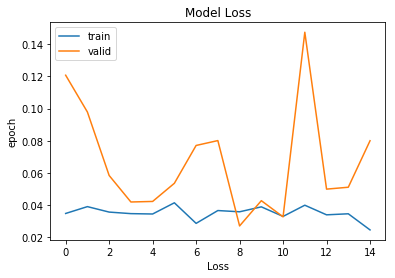

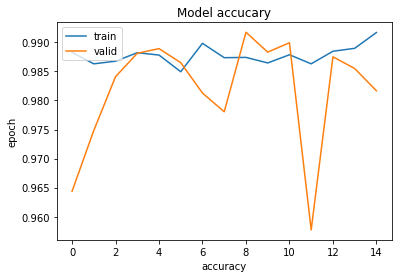

In [18]:
#batch_size=50的时候
show_loss(history)
show_acc(history)

#### 发现情况并没有好转,于是,准备使用更小的batch_size

In [ ]:
#训练模型看看
from keras.callbacks import ModelCheckpoint
import os

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras import Model


base_model=InceptionResNetV2(weights='imagenet',include_top=False)
for layer in base_model.layers:
    layer.trainable=False
    
x=GlobalAveragePooling2D()(base_model.output)
x=Dense(512)(x)
x=Dropout(0.2)(x)
# 添加一个分类器，我们有2个类
predictions=Dense(1,activation='sigmoid')(x)

# 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
for i, layer in enumerate(model.layers):
    print(i, layer.name)
    
#输出模型的样式
model.summary()

###设置训练模型的epochs的数量
epochs = 15
batch_size=30
check_point_filepath='./saved_models/weights.best-{epoch:02d}-{val_acc:.5f}.hdf5'
saved_model_path='./saved_models'

#文件夹不存在,就创建文件夹
if not os.path.exists(saved_model_path):
    os.mkdir()
    
####设置检查点
checkpointer = ModelCheckpoint(filepath=check_point_filepath, monitor='val_acc',verbose=1, save_best_only=True)

#设置回调
call_back=[checkpointer]

#加载数据
x_train_data=paths_to_tensor(x_train)
x_valid_data=paths_to_tensor(x_valid)

In [20]:
#使用更小的batch_size进行测试 
history= model.fit(x_train_data,y_train,validation_data=(x_valid_data,y_valid),epochs=epochs,batch_size=batch_size,callbacks=call_back)

Train on 19868 samples, validate on 4967 samples
Epoch 1/15
19868/19868 [==============================] - 200s 10ms/step - loss: 0.0851 - acc: 0.9697 - val_loss: 0.0197 - val_acc: 0.9948

Epoch 00001: val_acc improved from -inf to 0.99477, saving model to ./saved_models/weights.best-01-0.99477.hdf5
Epoch 2/15
19868/19868 [==============================] - 188s 9ms/step - loss: 0.0613 - acc: 0.9806 - val_loss: 0.1664 - val_acc: 0.9521

Epoch 00002: val_acc did not improve from 0.99477
Epoch 3/15
19868/19868 [==============================] - 187s 9ms/step - loss: 0.0532 - acc: 0.9821 - val_loss: 0.1063 - val_acc: 0.9702

Epoch 00003: val_acc did not improve from 0.99477
Epoch 4/15
19868/19868 [==============================] - 187s 9ms/step - loss: 0.0477 - acc: 0.9842 - val_loss: 0.0798 - val_acc: 0.9791

Epoch 00004: val_acc did not improve from 0.99477
Epoch 5/15
19868/19868 [==============================] - 187s 9ms/step - loss: 0.0423 - acc: 0.9855 - val_loss: 0.0598 - val_acc: 0

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


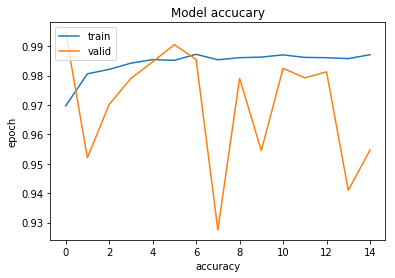

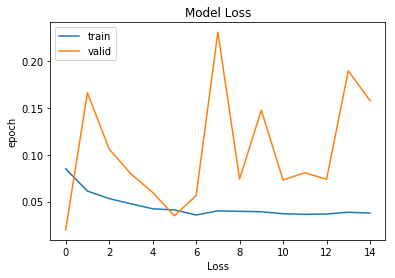

In [21]:
#batch=30的时候
show_acc(history)
show_loss(history)

In [9]:
#使用的batch_size为35
#训练模型看看
from keras.callbacks import ModelCheckpoint
import os

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras import Model


base_model=InceptionResNetV2(weights='imagenet',include_top=False)
for layer in base_model.layers:
    layer.trainable=False
    
x=GlobalAveragePooling2D()(base_model.output)
x=Dense(512)(x)
x=Dropout(0.2)(x)
# 添加一个分类器，我们有2个类
predictions=Dense(1,activation='sigmoid')(x)

# 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
for i, layer in enumerate(model.layers):
    print(i, layer.name)
    
#输出模型的样式
model.summary()

###设置训练模型的epochs的数量
epochs = 15
batch_size=35
check_point_filepath='./saved_models/weights.best-{epoch:02d}-{val_acc:.5f}.hdf5'
saved_model_path='./saved_models'

#文件夹不存在,就创建文件夹
if not os.path.exists(saved_model_path):
    os.mkdir()
    
####设置检查点
checkpointer = ModelCheckpoint(filepath=check_point_filepath, monitor='val_acc',verbose=1, save_best_only=True)

#设置回调
call_back=[checkpointer]

#加载数据
x_train_data=paths_to_tensor(x_train)
x_valid_data=paths_to_tensor(x_valid)

0 input_3
1 conv2d_407
2 batch_normalization_407
3 activation_407
4 conv2d_408
5 batch_normalization_408
6 activation_408
7 conv2d_409
8 batch_normalization_409
9 activation_409
10 max_pooling2d_9
11 conv2d_410
12 batch_normalization_410
13 activation_410
14 conv2d_411
15 batch_normalization_411
16 activation_411
17 max_pooling2d_10
18 conv2d_415
19 batch_normalization_415
20 activation_415
21 conv2d_413
22 conv2d_416
23 batch_normalization_413
24 batch_normalization_416
25 activation_413
26 activation_416
27 average_pooling2d_3
28 conv2d_412
29 conv2d_414
30 conv2d_417
31 conv2d_418
32 batch_normalization_412
33 batch_normalization_414
34 batch_normalization_417
35 batch_normalization_418
36 activation_412
37 activation_414
38 activation_417
39 activation_418
40 mixed_5b
41 conv2d_422
42 batch_normalization_422
43 activation_422
44 conv2d_420
45 conv2d_423
46 batch_normalization_420
47 batch_normalization_423
48 activation_420
49 activation_423
50 conv2d_419
51 conv2d_421
52 conv2d_42

  0%|          | 5/19868 [00:00<06:56, 47.72it/s]

conv2d_517 (Conv2D)             (None, None, None, 1 143360      activation_516[0][0]             
__________________________________________________________________________________________________
batch_normalization_517 (BatchN (None, None, None, 1 480         conv2d_517[0][0]                 
__________________________________________________________________________________________________
activation_517 (Activation)     (None, None, None, 1 0           batch_normalization_517[0][0]    
__________________________________________________________________________________________________
conv2d_515 (Conv2D)             (None, None, None, 1 208896      block17_8_ac[0][0]               
__________________________________________________________________________________________________
conv2d_518 (Conv2D)             (None, None, None, 1 215040      activation_517[0][0]             
__________________________________________________________________________________________________
batch_norm

100%|██████████| 4967/4967 [00:26<00:00, 185.72it/s]


In [10]:
#使用更小的batch_size进行测试 
history= model.fit(x_train_data,y_train,validation_data=(x_valid_data,y_valid),epochs=epochs,batch_size=batch_size,callbacks=call_back)

Train on 19868 samples, validate on 4967 samples
Epoch 1/15
19868/19868 [==============================] - 201s 10ms/step - loss: 0.1076 - acc: 0.9647 - val_loss: 0.1969 - val_acc: 0.9364

Epoch 00001: val_acc improved from -inf to 0.93638, saving model to ./saved_models/weights.best-01-0.93638.hdf5
Epoch 2/15
19868/19868 [==============================] - 186s 9ms/step - loss: 0.0624 - acc: 0.9788 - val_loss: 0.1602 - val_acc: 0.9491

Epoch 00002: val_acc improved from 0.93638 to 0.94906, saving model to ./saved_models/weights.best-02-0.94906.hdf5
Epoch 3/15
19868/19868 [==============================] - 186s 9ms/step - loss: 0.0539 - acc: 0.9819 - val_loss: 0.0247 - val_acc: 0.9930

Epoch 00003: val_acc improved from 0.94906 to 0.99295, saving model to ./saved_models/weights.best-03-0.99295.hdf5
Epoch 4/15
19868/19868 [==============================] - 186s 9ms/step - loss: 0.0525 - acc: 0.9816 - val_loss: 0.0796 - val_acc: 0.9779

Epoch 00004: val_acc did not improve from 0.99295
Ep

dict_keys(['val_acc', 'loss', 'acc', 'val_loss'])
dict_keys(['val_acc', 'loss', 'acc', 'val_loss'])


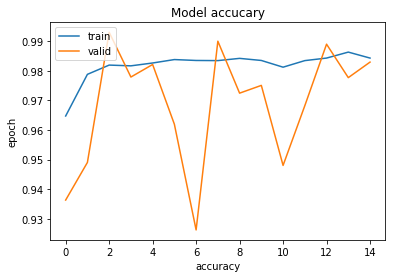

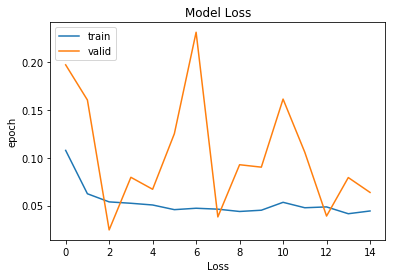

In [11]:
#batch=35的时候
show_acc(history)
show_loss(history)

In [15]:
#加载最佳模型权重进行测试
# 加载权重,进行fine-tune
from keras.callbacks import  EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras import Model


base_model=InceptionResNetV2(weights='imagenet',include_top=False)
for layer in base_model.layers:
    layer.trainable=False
    
x=GlobalAveragePooling2D()(base_model.output)
x=Dense(512)(x)
x=Dropout(0.2)(x)
# 添加一个分类器，我们有2个类
predictions=Dense(1,activation='sigmoid')(x)

# 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)
#先加载权重
model.load_weights('./saved_models/weights.best-01-0.99477.hdf5')

#z再锁层
for layer in model.layers:
    layer.trainable=False
    
for layer in model.layers[617:776]:
    layer.trainable=True
    
# 记得先编译    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#增加回调
early_stoping= EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='auto')
check_point_filepath='./saved_models/weights.best.valid-{epoch:02d}-{val_acc:.5f}.hdf5'

####设置检查点
checkpointer = ModelCheckpoint(filepath=check_point_filepath, monitor='val_loss',verbose=1, save_best_only=True)
call_backs=[early_stoping,checkpointer]

#也要更新下样本啊
x_train,x_valid,y_train,y_valid=train_test_split(X,Y,test_size=0.2,random_state=3456)

del x_train_data
del x_valid_data

#加载数据
x_train_data=paths_to_tensor(x_train)
x_valid_data=paths_to_tensor(x_valid)

#使用更小的batch_size进行测试 
history= model.fit(x_train_data,y_train,validation_data=(x_valid_data,y_valid),epochs=50,batch_size=40,callbacks=call_backs)

100%|██████████| 4967/4967 [00:27<00:00, 178.02it/s]


Train on 19868 samples, validate on 4967 samples
Epoch 1/50
19868/19868 [==============================] - 260s 13ms/step - loss: 0.0410 - acc: 0.9854 - val_loss: 0.0514 - val_acc: 0.9936

Epoch 00001: val_acc improved from -inf to 0.99356, saving model to ./saved_models/weights.best.valid-01-0.99356.hdf5
Epoch 2/50
19868/19868 [==============================] - 216s 11ms/step - loss: 0.0192 - acc: 0.9937 - val_loss: 0.0679 - val_acc: 0.9948

Epoch 00002: val_acc improved from 0.99356 to 0.99477, saving model to ./saved_models/weights.best.valid-02-0.99477.hdf5
Epoch 3/50
19868/19868 [==============================] - 216s 11ms/step - loss: 0.0155 - acc: 0.9953 - val_loss: 0.0680 - val_acc: 0.9936

Epoch 00003: val_acc did not improve from 0.99477
Epoch 4/50
19868/19868 [==============================] - 216s 11ms/step - loss: 0.0083 - acc: 0.9975 - val_loss: 0.2884 - val_acc: 0.9750

Epoch 00004: val_acc did not improve from 0.99477
Epoch 5/50
19868/19868 [============================

In [ ]:
# from keras.callbacks import  EarlyStopping

# base_model=InceptionResNetV2(weights='imagenet',include_top=False)
# for layer in base_model.layers:
#     layer.trainable=False
    
# x=GlobalAveragePooling2D()(base_model.output)
# x=Dense(512)(x)
# x=Dropout(0.2)(x)
# # 添加一个分类器，我们有2个类
# predictions=Dense(1,activation='sigmoid')(x)

# # 构建我们需要训练的完整模型
# model = Model(inputs=base_model.input, outputs=predictions)

# model.load_weights('./saved_models/weights.best-01-0.99477.hdf5')
# early_stoping= EarlyStopping(monitor='val_acc', patience=5, verbose=1, mode='auto')
# check_point_filepath='./saved_models/weights.best.valid-{epoch:02d}-{val_acc:.5f}.hdf5'
# ####设置检查点
# checkpointer = ModelCheckpoint(filepath=check_point_filepath, monitor='val_acc',verbose=1, save_best_only=True)
# call_backs=[early_stoping,checkpointer]

# #使用更小的batch_size进行测试 
# history= model.fit(x_train_data,y_train,validation_data=(x_valid_data,y_valid),epochs=300,batch_size=40,callbacks=call_backs)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


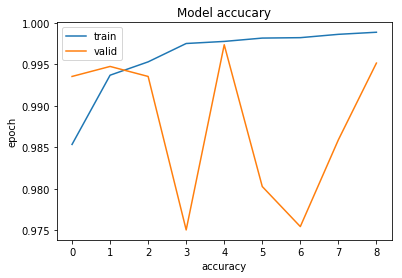

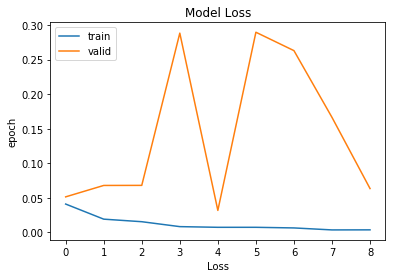

In [16]:
show_acc(history)
show_loss(history)

#### 经过多次尝试,我试了锁层,然后我就该检测下模型的成功率了

In [63]:
#写个方法加载验证集数据
import glob
import numpy as np
import os

def load_image_paths(path):
    '''输入相对路径,得到所有图片文件名'''
    paths=[]
    for i in range(1,12501):
        paths.append(path+str(i)+'.jpg')
    if len(paths)>0:
        return  np.array(paths)
    else:
        return None
    
def predict_images(model,file_names):
    '''根据名字输出是狗的概率'''
    x=paths_to_tensor(file_names)
    return model.predict(x)
    

In [18]:
del x_train_data
del x_valid_data

model.load_weights('./saved_models/weights.best.valid-05-0.99738.hdf5')

In [65]:
image_paths=load_image_paths('./test/')
result=predict_images(model,image_paths)

100%|██████████| 12500/12500 [01:09<00:00, 179.82it/s]


In [37]:
from pandas import DataFrame

def array_to_csv(array):
    dataframe=DataFrame(array)
    dataframe.index = np.arange(1, len(dataframe)+1)
    dataframe.to_csv('result.csv',index_label ='id',header=['label'])

In [66]:
# array_to_csv(result)
array_to_csv(result)
print(image_paths[0:50])
print(result[0:50])

['./test/1.jpg' './test/2.jpg' './test/3.jpg' './test/4.jpg'
 './test/5.jpg' './test/6.jpg' './test/7.jpg' './test/8.jpg'
 './test/9.jpg' './test/10.jpg' './test/11.jpg' './test/12.jpg'
 './test/13.jpg' './test/14.jpg' './test/15.jpg' './test/16.jpg'
 './test/17.jpg' './test/18.jpg' './test/19.jpg' './test/20.jpg'
 './test/21.jpg' './test/22.jpg' './test/23.jpg' './test/24.jpg'
 './test/25.jpg' './test/26.jpg' './test/27.jpg' './test/28.jpg'
 './test/29.jpg' './test/30.jpg' './test/31.jpg' './test/32.jpg'
 './test/33.jpg' './test/34.jpg' './test/35.jpg' './test/36.jpg'
 './test/37.jpg' './test/38.jpg' './test/39.jpg' './test/40.jpg'
 './test/41.jpg' './test/42.jpg' './test/43.jpg' './test/44.jpg'
 './test/45.jpg' './test/46.jpg' './test/47.jpg' './test/48.jpg'
 './test/49.jpg' './test/50.jpg']
[[1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+0

In [34]:
def loadCSVfile2(csv_file_name):
    tmp = np.loadtxt(csv_file_name, dtype=np.str, delimiter=",")
    data = tmp[1:,1:].astype(np.float)#加载数据部分
    label = tmp[1:,0].astype(np.float)#加载类别标签部分
    return data, label #返回array类型的数据

(array([[1.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [0.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [1.0000000e+00],
        [0.0000000e+00],
        [1.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [1.0000000e+00],
        [2.1354837e-31],
        [0.0000000e+00],
        [1.0000000e+00],
        [0.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [0.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [0.0000000e+00],
        [1.0000000e+00],
        [0.0000000e+00],
        [1.0000000e+00],
        [0.0000000e+00],
